In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2, glob
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

sn.set(font_scale = 1.4)

In [3]:
cars = glob.glob('../Data/vehicles_smallset/cars1/*.jpeg') + glob.glob('../Data/vehicles_smallset/cars2/*.jpeg') + glob.glob('../Data/vehicles_smallset/cars3/*.jpeg')
non_cars = glob.glob('../Data/non-vehicles_smallset/notcars1/*.jpeg') + glob.glob('../Data/non-vehicles_smallset/notcars2/*.jpeg') + glob.glob('../Data/non-vehicles_smallset/notcars3/*.jpeg')

In [4]:
def get_random_image(location_array):
    return mpimg.imread(location_array[np.random.randint(0, len(location_array))])

In [5]:
sample_car_image = get_random_image(cars)
sample_non_car_image = get_random_image(non_cars)

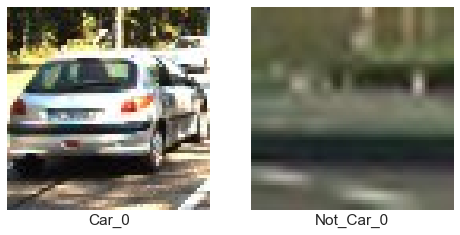

In [6]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(sample_car_image)
        ax.set_xlabel('Car_' + str(c))
    if i % 2 == 1:
        ax.imshow(sample_non_car_image)
        ax.set_xlabel('Not_Car_' + str(c))
        c += 1
plt.show()

In [7]:
def flattened_color_features(image, size = (32, 32)):
    return cv2.resize(image, size).ravel()

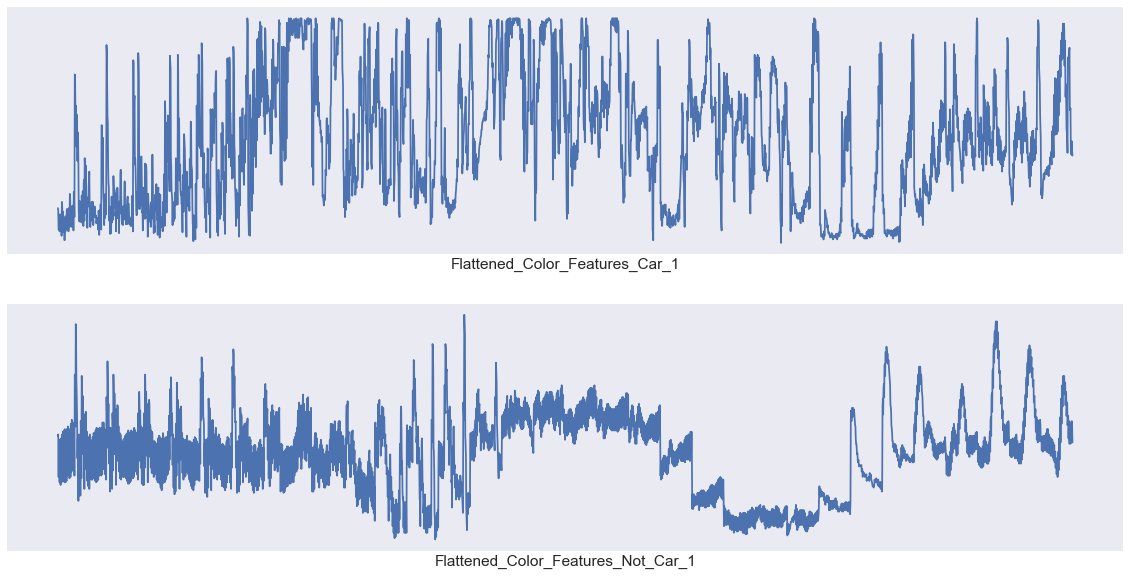

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(flattened_color_features(sample_car_image))
        ax.set_xlabel('Flattened_Color_Features_Car_' + str(c))
    if i == 1:
        ax.plot(flattened_color_features(sample_non_car_image))
        ax.set_xlabel('Flattened_Color_Features_Not_Car_' + str(c))
plt.show()

In [9]:
def get_histogram_features(image, bins = 32, _range = (0, 256)):
    channel_1_histogram = np.histogram(image[:, :, 0], bins = bins, range = _range)
    channel_2_histogram = np.histogram(image[:, :, 1], bins = bins, range = _range)
    channel_3_histogram = np.histogram(image[:, :, 2], bins = bins, range = _range)
    histogram_features = np.concatenate((channel_1_histogram[0], channel_1_histogram[0], channel_1_histogram[0]))
    return histogram_features

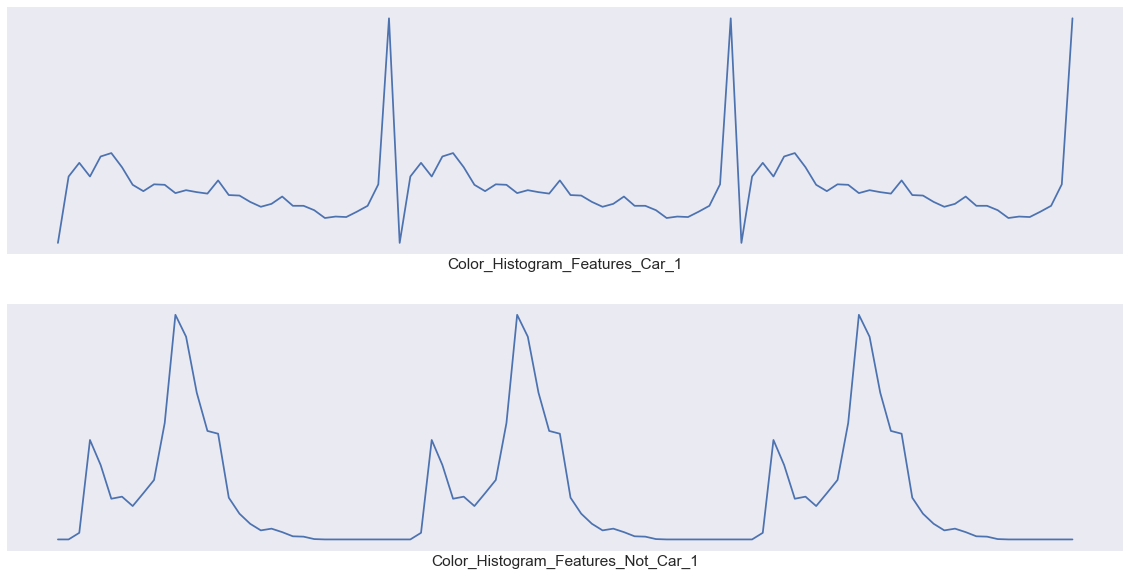

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(get_histogram_features(sample_car_image))
        ax.set_xlabel('Color_Histogram_Features_Car_' + str(c))
    if i == 1:
        ax.plot(get_histogram_features(sample_non_car_image))
        ax.set_xlabel('Color_Histogram_Features_Not_Car_' + str(c))
plt.show()

In [11]:
def get_features(image, colorspace = 'RGB', size = (32, 32), bins = 32, _range = (0, 256)):
    if colorspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif colorspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif colorspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif colorspace == 'RGB' or colorspace == 'BGR':
        feature_image = np.copy(image)
    flattend_spatial_features = flattened_color_features(feature_image, size)
    histogram_features = get_histogram_features(feature_image, bins, _range)
    features = np.concatenate((flattend_spatial_features, histogram_features))
    return features

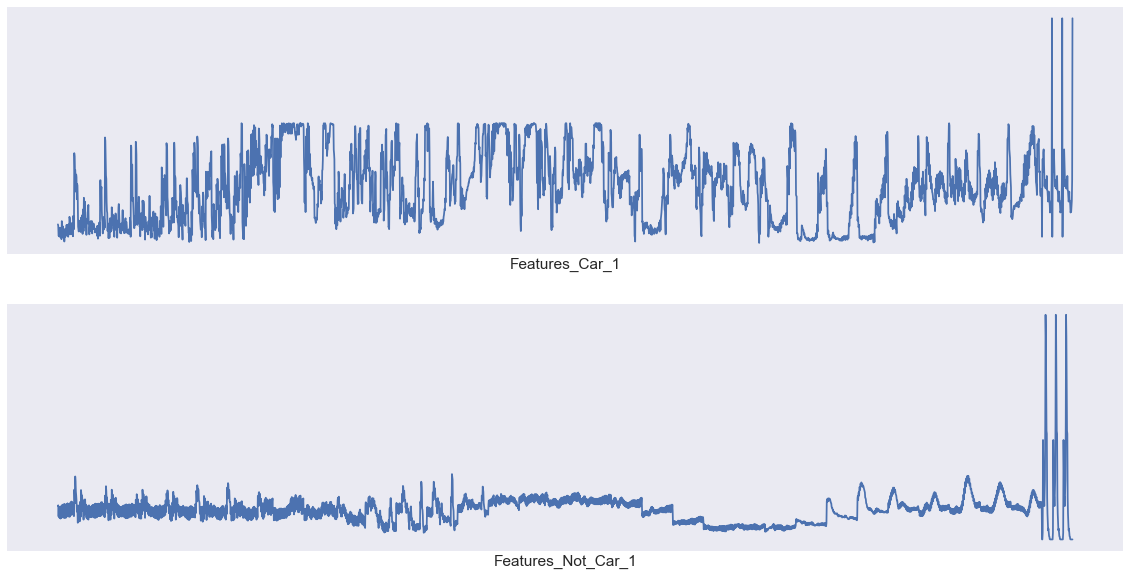

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(get_features(sample_car_image))
        ax.set_xlabel('Features_Car_' + str(c))
    if i == 1:
        ax.plot(get_features(sample_non_car_image))
        ax.set_xlabel('Features_Not_Car_' + str(c))
plt.show()

In [13]:
features_cars = [get_features(mpimg.imread(image_location)) for image_location in cars]
features_not_cars = [get_features(mpimg.imread(image_location)) for image_location in non_cars]
label_cars = [1] * len(cars)
label_not_cars = [0] * len(non_cars)

In [14]:
print('Number of car images:', len(cars))
print('Number of non car images:', len(non_cars))

Number of car images: 1196
Number of non car images: 1125


In [15]:
x = features_cars + features_not_cars
x = np.vstack(x).astype(np.float64)
y = label_cars + label_not_cars
y = np.vstack(y).astype(np.float64)
x.shape, y.shape

((2321, 3168), (2321, 1))

In [16]:
x_scaler = StandardScaler().fit(x)
x_scaled = x_scaler.transform(x)
x_scaled.shape

(2321, 3168)

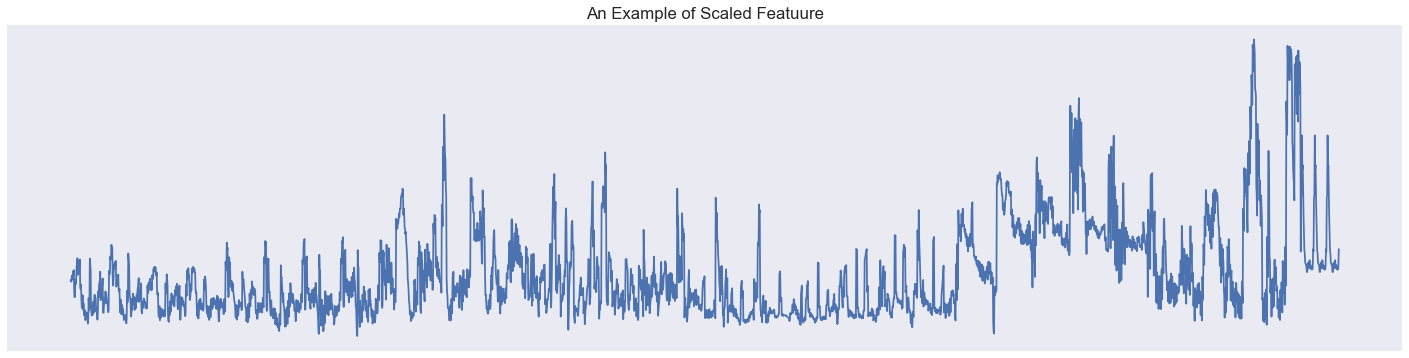

In [17]:
plt.figure(figsize = (25, 6))
plt.plot(x_scaled[np.random.randint(0, len(cars) + len(non_cars))])
plt.xticks([])
plt.yticks([])
plt.title('An Example of Scaled Featuure')
plt.show()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 100)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1856, 3168), (465, 3168), (1856, 1), (465, 1))

In [19]:
svc = LinearSVC()

In [20]:
svc.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [21]:
print('Train Accuracy of SVC = ', svc.score(x_train, y_train))

Train Accuracy of SVC =  1.0


In [22]:
print('Test Accuracy of SVC = ', svc.score(x_test, y_test))

Test Accuracy of SVC =  0.978494623655914


In [23]:
print('F1-Score of SVC = ', f1_score(y_test, svc.predict(x_test)))

F1-Score of SVC =  0.9796747967479674


In [24]:
cm = confusion_matrix(y_test, svc.predict(x_test))

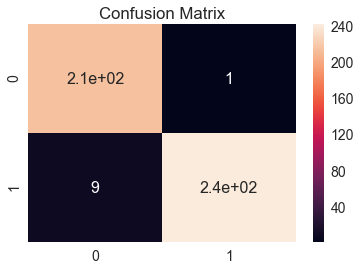

In [25]:
sn.heatmap(pd.DataFrame(cm), annot = True, annot_kws = {"size": 16})
plt.title('Confusion Matrix')
plt.show()